In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import pyTSL as pt
import warnings
import datetime as dt
warnings.filterwarnings('ignore')
from Config import factor_config as fc
from Config import model_config as mc
import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt

head_future = pd.read_excel(os.path.join(fc.head_path, 'IC_head_future.xlsx')) # 每日主流合约

def read_file(date):
    '''
    根据日期读取对应主头合约文件
    '''
    read_date = date.strftime('%Y%m%d')
    next_idx = head_future[head_future['trade_date'] == date].index
    if next_idx == 0:
        return None
    read_future = head_future.iloc[next_idx - 1]['IC'].values[0]
    read_file = read_future + '_' + read_date + '.tdf'
    return read_file


def get_data():
    '''
    读取因子及涨跌幅数据
    '''
    factor_df = pd.read_excel('factor_data.xlsx')
    file_dates = pd.to_datetime(factor_df['minute'].dt.date).drop_duplicates()
    file_dates = file_dates[(file_dates > mc.start_date) & (file_dates <= mc.end_date)]
    file_dates = file_dates.reset_index(drop=True)
    factor_df['minute'] = pd.to_datetime(factor_df['minute'])
    factor_df = factor_df[pd.to_datetime(factor_df['minute'].dt.date).isin(file_dates)]
    factor_df = factor_df.set_index('minute')

    # 获取涨跌幅数据
    return_list = list()
    for d_ in tqdm(file_dates, desc='Getting data'):
        
        # 选取期货数据
        f_path = read_file(d_)
        f_return = pd.read_pickle(os.path.join(fc.kline_data, f_path))[['date', 'price', 'vol']]
        
        # 处理时间
        f_return['date'] = f_return.apply(lambda x: pt.DoubleToDatetime(x['date']), axis=1)
        f_return['amount'] = f_return['price'] * f_return['vol']
        f_return['minute'] = f_return['date'].dt.floor('T')
        
        # 合并每分钟数据
        f_return['amount'] = f_return['price'] * f_return['vol']
        vwap = f_return.groupby('minute').apply(lambda x: x['amount'].sum() / x['vol'].sum())
        vwap = vwap.dropna()
        vwap = pd.DataFrame(vwap, columns=['vwap'])

        # 调整涨跌幅为yield_periods
        vwap['return'] = vwap['vwap'].pct_change(mc.yield_periods)
        vwap = vwap.reset_index()

        vwap = vwap[['minute', 'return']]
        return_list.append(vwap)

    return_df = pd.concat(return_list)

    # 合并涨跌幅与因子数据
    return_df = return_df.set_index('minute')
    return_df[mc.model_factor] = factor_df
    return_df = return_df.dropna(subset=['return'])
    return_df = return_df.reset_index('minute')

    return return_df

Step 1: Starting Rolling Training...


Extended Tuning: 100%|██████████| 20/20 [19:07<00:00, 57.37s/it]


Step 2: Plotting Results...


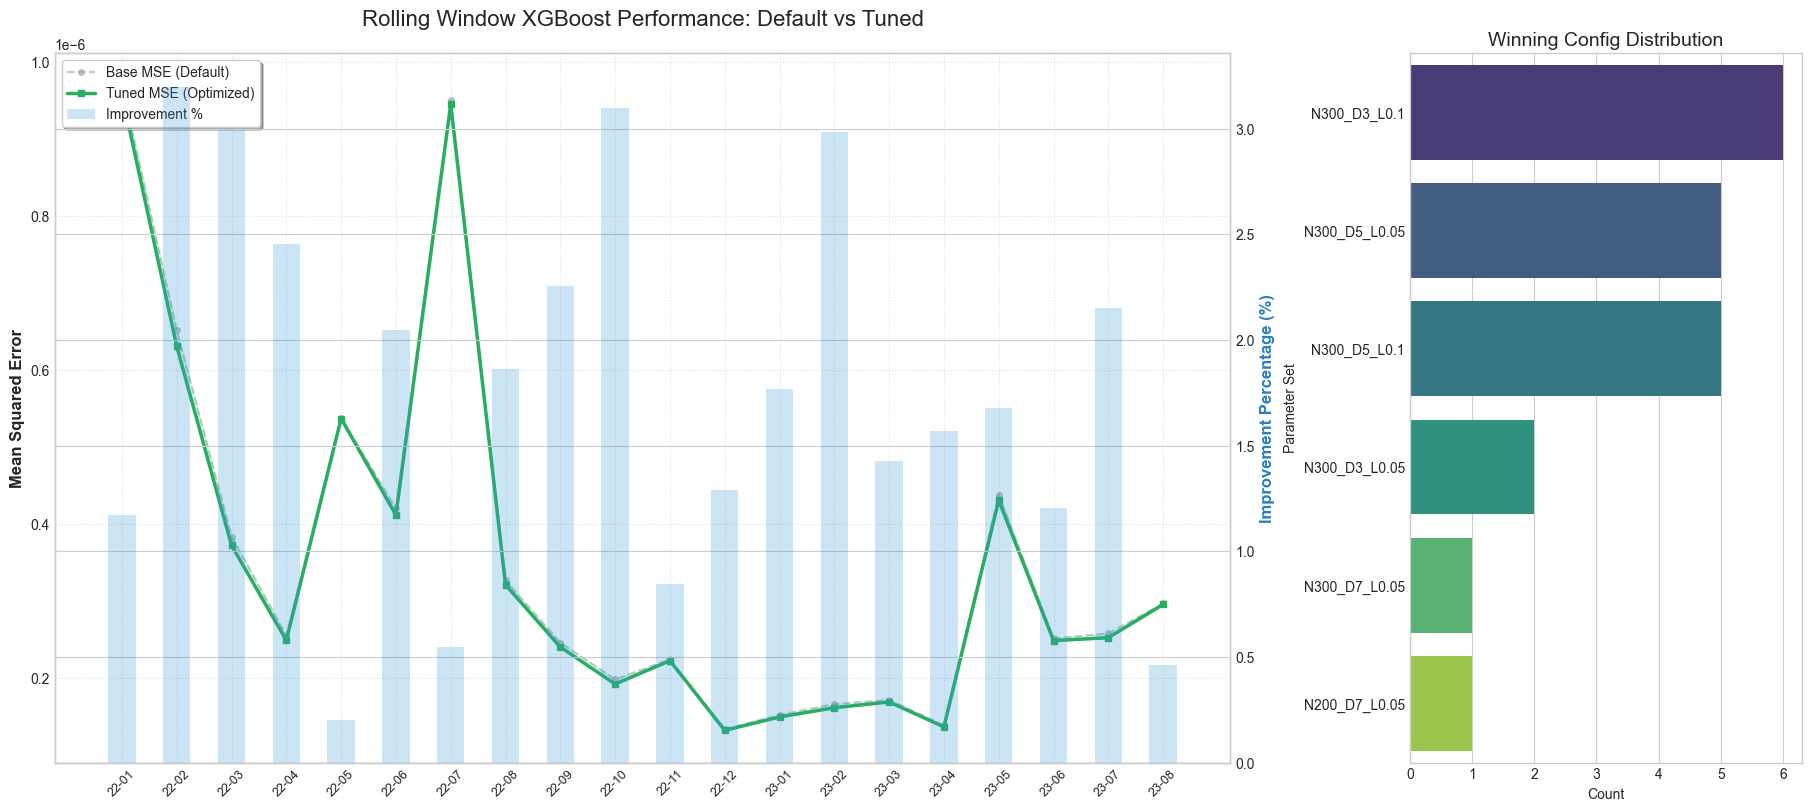


=== Summary ===
Average Improvement: 1.76%
Top Winning Config: N300_D3_L0.1


In [2]:
def run_rolling_tuning_extended():
    """
    多维度的滚动调参
    """
    data = get_data()
    data['date'] = pd.to_datetime(data['minute'].dt.date)
    data = data.set_index('date').sort_index()
    
    full_dates = pd.date_range(mc.start_date, mc.end_date, freq='MS')
    required_months = mc.train_month + mc.test_month
    train_start_dates = full_dates[: -required_months]
    
    results = []
    winning_configs = []

    search_grid = {
        'n_estimators': [100, 200, 300],          # 树的数量
        'max_depth': [3, 5, 7],                  # 复杂度
        'learning_rate': [0.01, 0.05, 0.1],      # 学习率
        'subsample': [0.8, 1.0],                 # 样本采样
        'colsample_bytree': [0.8, 1.0]           # 特征采样
    }

    for i in tqdm(range(len(train_start_dates)), desc='Extended Tuning'):

        train_start = train_start_dates[i]
        train_end = train_start + pd.DateOffset(months=mc.train_month)
        test_end = train_end + pd.DateOffset(months=mc.test_month)

        mask_train = (data.index >= train_start) & (data.index < train_end)
        mask_test = (data.index >= train_end) & (data.index < test_end)
        
        train_x = data.loc[mask_train, mc.model_factor].copy()
        train_y = data.loc[mask_train, 'return'].copy()
        test_x = data.loc[mask_test, mc.model_factor].copy()
        test_y = data.loc[mask_test, 'return'].copy()
        
        if train_x.empty or test_x.empty: continue

        # 2. 滚动标准化
        scaler = StandardScaler()
        train_x_s = pd.DataFrame(scaler.fit_transform(train_x), index=train_x.index, columns=train_x.columns)
        test_x_s = pd.DataFrame(scaler.transform(test_x), index=test_x.index, columns=test_x.columns)

        # 3. 基准模型
        base_model = xgb.XGBRegressor(**mc.xgb_params)
        base_model.fit(train_x_s, train_y)
        mse_base = mean_squared_error(test_y, base_model.predict(test_x_s))

        # 4. 多维度网格搜索
        best_mse = mse_base
        win_param_label = "Default"
        
        for n_est in search_grid['n_estimators']:
            for d in search_grid['max_depth']:
                for lr in search_grid['learning_rate']:
                    for ss in search_grid['subsample']:
                        for cs in search_grid['colsample_bytree']:
                            params = mc.xgb_params.copy()
                            params.update({
                                'n_estimators': n_est,
                                'max_depth': d,
                                'learning_rate': lr,
                                'subsample': ss,
                                'colsample_bytree': cs,
                                'n_jobs': -1,      
                                'random_state': 42 
                            })
                            
                            m = xgb.XGBRegressor(**params)
                            m.fit(train_x_s, train_y)
                            mse_curr = mean_squared_error(test_y, m.predict(test_x_s))
                            
                            if mse_curr < best_mse:
                                best_mse = mse_curr

                                win_param_label = f"N{n_est}_D{d}_L{lr}"

        # 5. 记录
        results.append({
            'Month_Str': train_start.strftime('%y-%m'),
            'Base_MSE': mse_base,
            'Tuned_MSE': best_mse,
            'Improve_Pct': (mse_base - best_mse) / mse_base * 100,
            'Winner': win_param_label
        })
        winning_configs.append(win_param_label)

    return pd.DataFrame(results), winning_configs



def plot_tuning_results(res_df, winning_configs):
    """
    接收计算结果，绘制静态分析图表。
    """
    # 绘图风格
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 创建画布
    fig = plt.figure(figsize=(18, 8), constrained_layout=True)
    gs = gridspec.GridSpec(1, 4, figure=fig)
    
    # === 左图：MSE 趋势与改善率 ===
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = ax1.twinx()
    
    x_axis = res_df['Month_Str']
    
    # 绘制 MSE 曲线
    l1, = ax1.plot(x_axis, res_df['Base_MSE'], 'o--', color='#95a5a6', label='Base MSE (Default)', alpha=0.6, markersize=4)
    l2, = ax1.plot(x_axis, res_df['Tuned_MSE'], 's-', color='#27ae60', label='Tuned MSE (Optimized)', linewidth=2.5, markersize=5)
    
    # 填充改善区域
    ax1.fill_between(x_axis, res_df['Base_MSE'], res_df['Tuned_MSE'], color='#2ecc71', alpha=0.15, label='Performance Gain')
    
    # 绘制改善率柱状图 (右轴)
    # 使用条形图展示 Improvement %，颜色根据是否提升变化
    colors = ['#3498db' if x > 0 else '#e74c3c' for x in res_df['Improve_Pct']]
    b1 = ax2.bar(x_axis, res_df['Improve_Pct'], color=colors, alpha=0.25, width=0.5, label='Improvement %')
    
    # 设置标签与图例
    ax1.set_ylabel('Mean Squared Error', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Improvement Percentage (%)', fontsize=12, fontweight='bold', color='#2980b9')
    ax1.set_title('Rolling Window XGBoost Performance: Default vs Tuned', fontsize=16, pad=20)
    
    # 合并图例
    lines = [l1, l2, b1]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', frameon=True, fancybox=True, shadow=True)
    
    # x轴标签旋转，防止重叠
    ax1.set_xticks(range(len(x_axis)))
    ax1.set_xticklabels(x_axis, rotation=45, fontsize=9)
    ax1.grid(True, linestyle=':', alpha=0.6)

    # === 右图：最优参数统计 ===
    ax3 = fig.add_subplot(gs[0, 3])
    
    # 统计获胜参数的频次
    sns.countplot(y=winning_configs, ax=ax3, order=pd.Series(winning_configs).value_counts().index, palette='viridis')
    
    ax3.set_title('Winning Config Distribution', fontsize=14)
    ax3.set_xlabel('Count')
    ax3.set_ylabel('Parameter Set')
    
    # 保存或展示
    plt.savefig('tuning_result.png', dpi=300)
    plt.show()


if __name__ == '__main__':
    # 1. 运行计算
    print("Step 1: Starting Rolling Training...")
    results_df, winning_configs = run_rolling_tuning_extended()
    
    # 2. 运行绘图
    print("Step 2: Plotting Results...")
    plot_tuning_results(results_df, winning_configs)
    
    # 3. 打印摘要
    print("\n=== Summary ===")
    avg_improve = results_df['Improve_Pct'].mean()
    print(f"Average Improvement: {avg_improve:.2f}%")
    print("Top Winning Config:", pd.Series(winning_configs).mode()[0])